<a href="https://colab.research.google.com/github/xslittlemaggie/Deep-Learning-Machine-Learning-Projects/blob/master/Loan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> LendingClub Loan Data Analysis & Model Building Report </center></h1>

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 24px">
    <ol>
        <li><a href="#purpose of the study">Project Understanding</a></li>
        <li><a href="#loading_data">Data Loading</a></li>
        <li><a href="#features exploratory">Data Exploratory</a></li>
        <li><a href="#data preprocessing">Data Preprocessing</a></li>
        <li><a href="#features engineering">Features Engineering</a></li>
        <li><a href="#model building">Model Buildings</a></li>
        <li><a href="#conclusion">Conclusion</a></li>
    </ol>
</div>
<br>
<hr>

# 0: Import libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode

# 1. Project Understanding

**1. The Purpose：**

The purpose of this project is to analyze the features related to the loan risks and create models (high accuracy, auc scores) to evaluate the risks in loan. 

**2. The Data:**

The LendingClub dataset loaded from Kaggle competition will be used for this project. 

The raw dataset includes 42538 samples and 145 features, which is large enough for data analysis. 

**3. The models:**

(1). Logistic Regression: Easy understanding

(2). Random Forest: Complex, could be more accurate, but less explainable

# 2. Load dataset from Kaggle

In [0]:
import os

os.environ['KAGGLE_USERNAME'] = "liulihuang" # username from the json file 
os.environ['KAGGLE_KEY'] = "7adfc6c4e6c5eec087031fbb7397aee5" # key from the json file (This key is incorrect) 

In [3]:
!pip install -q kaggle
!kaggle datasets list -s lending-club-loan-data  # It will list the 20 datasets including "lending-club-loan-data" from kaggle
!kaggle datasets download -d balaji1994/lending-club-loan-data -p /content/
!unzip -q /content/lending-club-loan-data.zip -d /content/lending-club-loan-data/

ref                                  title                        size  lastUpdated          downloadCount  
-----------------------------------  --------------------------  -----  -------------------  -------------  
wendykan/lending-club-loan-data      Lending Club Loan Data      702MB  2019-03-18 18:43:12          57298  
wordsforthewise/lending-club         All Lending Club loan data  618MB  2019-04-10 18:03:34           5634  
skihikingkevin/online-p2p-lending    Online P2P Lending           77MB  2018-08-30 20:32:43            693  
mrferozi/loan-data-for-dummy-bank    Loan Data for Dummy Bank     28MB  2018-08-04 12:45:51           1496  
saurabh13nov/lending-club-loan-data  Lending Club Loan Data      105MB  2017-08-08 20:43:56            107  
balaji1994/lending-club-loan-data    Lending Club Loan Data       35MB  2018-11-20 06:49:37             24  
savasy/loan-data-sampled             Loan data sampled             1MB  2017-11-21 08:28:34             38  
 96% 33.0M/34.5M [0

In [4]:
loans = pd.read_csv("/content/lending-club-loan-data/LoanStats3a.csv", skiprows = 1)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# the dictionary to check the details of the features
dic = pd.read_excel("/content/lending-club-loan-data/LCDataDictionary (1).xlsx")

# 3. Data Exploratory (数据探索)


Get familiar with the data before data preprocessing, feature engineering, and model building. 
Drop the features which are obviously unrelated to the target, with all missing values, or with the same values.

## 3.1 Get familar with the dataset

In [0]:
# read the first five samples
# loans.head()  # commented to save space

In [0]:
# descriptive about the features
# loans.describe().T  # commented to save space

## 3.2 Go through each of the feature roughly & prepare for the data engineering later
1. **numerical features**, consider to drop the features very unbalanced
2. **string, text features**, need recoding later 
3. **features with the same value**, such feature wond't contribute to the model, consider to drop these features
4. **other features**, obviously not related to the target, or are highly related to other features, 

In [0]:
# select features which 100% of the data is missing
all_missing_features = [feature for feature in loans.columns if ((loans[feature].isnull().sum()) == loans.shape[0])]
# drop all missing features
loans.drop(all_missing_features, axis = 1, inplace = True)

Since no matter how important the features are, if all the values are missing, such features will make no contribution to the model. 

After removing the features with all missing values, the number of columns is 51 now, which will make the data more readable and managable.

### 3.2.1 After deleting the features with all missing values, go through each of the rest feature, and clusterthem into different class, numerical, categorical, text, etc.

In [11]:
print("Number of features: {}, sample size: {}".format(loans.shape[1], loans.shape[0]))
print(loans.columns)

Number of features: 64, sample size: 42538
Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bank

### Sample size : 42538

**1. Numerical features**
- **delinq_2yrs**: very unbalanced, 37771 zeros vs 3595 1 - 13 in total
- **mths_since_last_record**: very unbalanced, 38887 (91.4%) missing values
- **pub_rec**: very unbalanced, 40130 zeros (94%)
- **out_prncp**: very unbalanced, 42535 zeros (99.99%) vs 3 Nan **drop now**
- **out_prncp_inv**: 42535 zeros (99.99%) vs 3 Nan **drop now**
- **collections_12_mths_ex_med**: very unbalanced, 42390 (99.65%) zeros vs 148 Nan **drop now**
- **policy_code**: very unbalanced, 42535 zeros (99.99%) vs 3 Nan **drop now**
- **acc_now_delinq**: very unbalanced, 42502 zeros (99.9%) vs 4 ones **drop now**
- **chargeoff_within_12_mths**: very unbalanced, 42390 zeros (99.65%) vs 148 Nan **drop now**
- **delinq_amnt**: very unbalanced, 42504 zeros (99.9%) vs 33 others **drop now**
- **tax_liens**: very unbalanced, 42429 zeros (99.74%) vs 109 Nan **drop now**
- **total_rec_late_fee**: very unbalanced, more than 30000 zeros
- **recoveries**: very unbalanced, more than 30000 zeros
- **collection_recovery_fee**: very unbalanced, more than 35000 zeros
- **pub_rec_bankruptcies**: very unbalanced, more than 38000 zeros

**2. Categorical features**
- **id**: only 3 non missing values, **drop now**
- **pymnt_plan**: all n **drop now**
- **initial_list_status**: 42535 N (99.99%) vs 3 Nan **drop now**
- **application_type**: 42535 Individual (99.99%) vs 3 Nan **drop now**
- **hardship_flag**: 42535 N (99.99%) vs 3 Nan **drop now**
- **disbursement_method**: 42535 CASH (99.99%) vs 3 Nan **drop now**
- **debt_settlement_flag**: very imbalanced, 42375 Y (99.6%) vs 160 N
- **term**: e.g. 36 months
- **int_rate**: e.g. 10%
- **grade**: e.g. A
- **sub_grade**: e.g. B2 
- **emp_title**: e.g. US Army
- **emp_length**: e.g. 10+ years
- **home_ownership**: e.g. RENT
- **verification_status**: e.g. Verified
- **purpose**: debt_consolidation
- **addr_state**: 
- **revol_util**: 83%

**3. Object, string, text features, need recoding**
- **issue_d**: e.g. Dec-2011
- **earliest_cr_line**: e.g. Dec-2011
- **last_pymnt_d**: e.g. Dec-2011
- **last_credit_pull_d**: e.g. Dec-2011
- **next_pymnt_d**: e.g. Dec-2011, very unbalanced, 39789 missing values (93.5%) ** drop now**

**4. Features after the Charged Off, only this group of people have such info, thus need to be removed**
- **debt_settlement_flag_date**: 42378 Nan **drop now**
- **settlement_status**: 42378 Nan **drop now**
- **settlement_date**: 42378 Nan **drop now**
- **settlement_amount**: 42378 Nan **drop now**
- **settlement_percentage**: 42378 Nan **drop now**
- **settlement_term**: 42378 Nan **drop now**
- **debt_settlement_flag**: 42378 Nan **drop now**


**5. Other features, not related to the project, or highly related to other features consider drop**
- **zip_code**: 860xx
- **desc**: e.g. Debt Consolidation **(This feature is similar to feature purpose)** 

In [123]:
# delete the features with > 99% missing values, or 99% of values are the same
features_to_drop = ["id", "pymnt_plan", "desc", "zip_code", "initial_list_status", "out_prncp", "out_prncp_inv", "collections_12_mths_ex_med", "policy_code", "application_type",
                   "acc_now_delinq", "chargeoff_within_12_mths", "delinq_amnt", "tax_liens", "hardship_flag", "disbursement_method", "debt_settlement_flag", 
                    "debt_settlement_flag_date", "next_pymnt_d", "settlement_status", "settlement_date", "settlement_amount", "settlement_percentage", "settlement_term"]

loans.drop(features_to_drop, axis = 1, inplace = True)

KeyError: ignored

In [0]:
# numerical features, some of the features could be removed, thus don't need to update
num_features = ["loan_amnt", "funded_amnt", "funded_amnt_inv", "installment", "annual_inc", "dti", "delinq_2yrs", "inq_last_6mths", 
                "mths_since_last_delinq", "mths_since_last_record", "open_acc", "pub_rec", "revol_bal", "total_pymnt", "total_pymnt_inv", 
                "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_amnt",
                "pub_rec_bankruptcies"]

In [0]:
#string, text features, need recode, after further analysis, some of the features could be removed, I need to update the features for later data engineering
cat_features = ["term", "grade", "sub_grade", "emp_title", "emp_length", "home_ownership", "verification_status", "purpose","title", "addr_state"]

# numerical values with % sign, need recoding
text_features = ["int_rate", "revol_util", "total_acc"]

# date features
date_features = ["issue_d", "earliest_cr_line", "last_pymnt_d", "last_credit_pull_d"]

Till now, I haven't done any computation to the whole datase. I only did a rough general overview and cleaning to the whole dataset, and have some insights about how I will deal with the data later.  

I will do the data cleaning, data engineering before aplitting the training, validation, testing data to avoid data leakage. 

### 3.2.1 Visualization of target feature: loan_status

In [113]:
loans.loan_status.value_counts()

Fully Paid                                             34116
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64

In [0]:
# only keep the rows loan_status = "Fully Paid" or "Charged Off"
loans = loans.loc[loans["loan_status"].isin(["Fully Paid", "Charged Off"])]

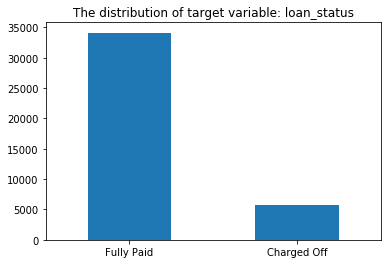

In [115]:
plt.figure(figsize = (6, 4))
loans["loan_status"].value_counts().plot(kind = "bar")
plt.title("The distribution of target variable: loan_status")
plt.xticks(rotation = 0)
plt.show()

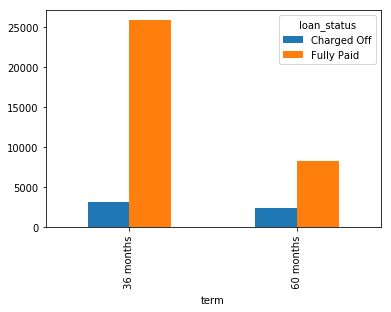

In [218]:
pvt = pd.pivot_table(loans[["loan_status", "term"]], index = "term", columns = "loan_status", aggfunc = len)
pvt.plot(kind = "bar")

From the result above, the target variable **loan_status** is composed of two classes: Fully Paid (完全结清), & Charged Off (坏账注销). 

The dataset is imbalanced, and need further consideration later. 

### 3.3.2 Visualization of the categorical features (分类变量的分布)

探索典型分类变量依据好坏样本两类的分布并进行可视化展示：

In [0]:
# list of the categorical/class features
cat_features = ["term", "int_rate", "grade", "sub_grade", "emp_title", "emp_length", "home_ownership", "verification_status", "purpose","title", "debt_settlement_flag",
                  "last_credit_pull_d",  "addr_state"]

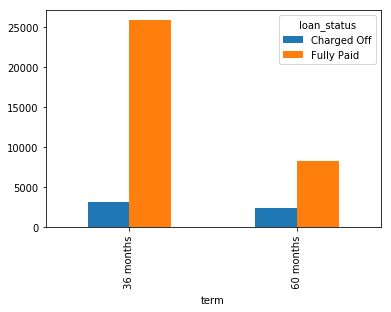

In [117]:
pvt = pd.pivot_table(loans[["loan_status", "term"]], index = "term", columns = "loan_status", aggfunc = len)
pvt.plot(kind = "bar")
plt.show()

From the figure above, most people select the 36 months term. The percentage of 60 months loans are more likely to charged off.  
借款人多选择３６期贷款，选择６０期贷款的违约率要高一些。

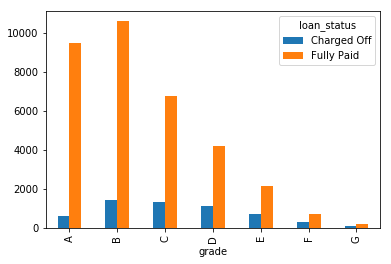

In [118]:
pvt = pd.pivot_table(loans[["loan_status", "grade"]], index = "grade", columns = "loan_status", aggfunc = len)
pvt.plot(kind = "bar")
plt.show()

In [0]:
for fea in cat_features:
  pvt = pd.pivot_table(loans[["loan_status", fea]], index = fea, columns = "loan_status", aggfunc = len)
  # plot pivot table with bar plot, green bar represent fully paid
  pvt.plot(kind = 'bar', color = ['r', 'b'])

由上图：

我们需要首先理解一下grade这个特征。grade是ＬＣ自评等级，不同的网贷平台投资人有不一样的风险收益偏好，ＬＣ平台依据这种多样化的需求，将借贷人分成Ａ－Ｇ七个等级。

ＬＣ使用复杂的算法对每笔贷款予以评级，这个评级和借款人的利率息息相关（这也说明，grade与某些特征是存在关系的）。比如说，那些信用历史好，还款能力好的借款人利率偏低，约７％，其贷款等级通常为Ａ级。从Ａ到Ｇ，贷款的风险越来越高，利率也越来越高。

从图中，我们也可以看出这个趋势。

另外，无论是投资人还是借贷者，大多数都是选择较低风险较低收益的类型。

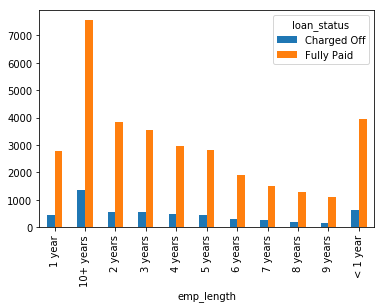

In [119]:
pvt = pd.pivot_table(loans[["loan_status", "emp_length"]], index = "emp_length", columns = "loan_status", aggfunc = len)
pvt.plot(kind = "bar")
plt.show()

由上图：

工作时长低于１年（包括１年）与１０年以上的借款人最多，两者的违约比例相差不大，这张图打破了人们惯常以为的工作年限长就靠谱的想法。除此两类，在２－９年内，随着工作年限越长，贷款需求越少，可能是因为收入越来越稳定吧。

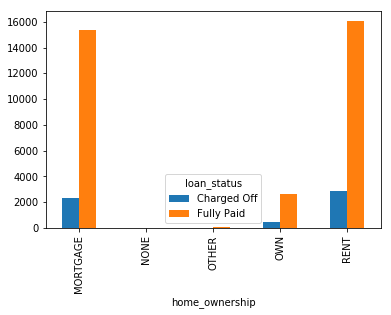

In [120]:
pvt = pd.pivot_table(loans[["loan_status", "home_ownership"]], index = "home_ownership", columns = "loan_status", aggfunc = len)
pvt.plot(kind = "bar")
plt.show()

由上图：

借款人住房按揭、租房最多，违约率不相上下；

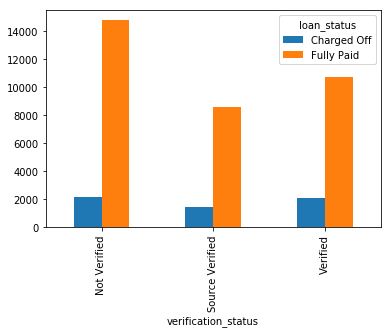

In [121]:
pvt = pd.pivot_table(loans[["loan_status", "verification_status"]], index = "verification_status", columns = "loan_status", aggfunc = len)
pvt.plot(kind = "bar")
plt.show()

由上图：

表征收入或收入来源是否经过核实。大部分借款是经过核实的，经过简单计算可知，核实的借款违约率约为0.15，未经核实的违约率约为0.14.可以说明网上提交的申请数据还是比较诚实的。另外，也可以初步推断，这个变量的预测能力应该不是特别强。

### 3.3.3 Visualization of the numerical features (连续值特征分布)

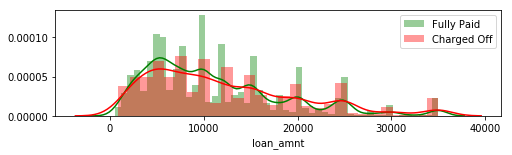

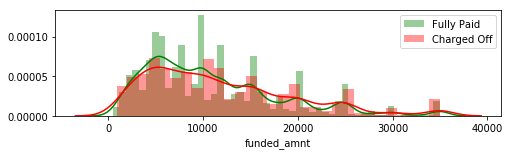

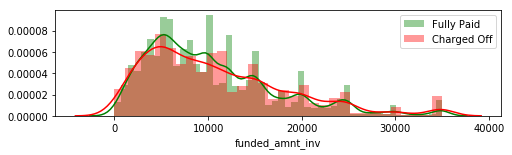

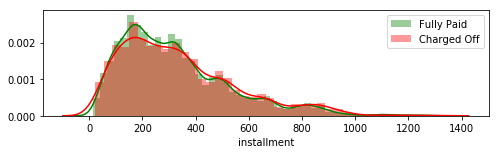

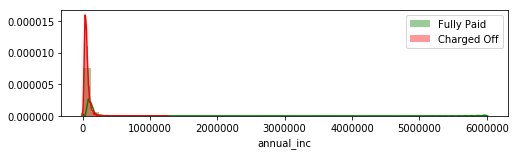

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt
num_feas = [i for i in loans.columns[2:30] if loans[i].dtype == 'float']
for i, fea in enumerate(num_features[:5]):
  plt.figure(figsize = (8, 6 * len(num_features[:5])))
  plt.subplot(len(num_feas), 1, i + 1)
  df_temp_0 = loans[fea][loans.loan_status == 'Fully Paid']
  df_temp_1 = loans[fea][loans.loan_status == 'Charged Off']
  sns.distplot(df_temp_0.dropna(), color = 'g')
  sns.distplot(df_temp_1.dropna(), color = 'r')
  plt.legend(['Fully Paid', 'Charged Off'])
  plt.show()

从这些图中可以初步得出如下信息：

贷款额度、分期付款金额成有些长尾的正态分布，说明贷款额度集中在中小额度，但是也有分散的大额度

年收入集中在０－１０万刀以内，但是也有极高收入（最高达到６００万）的借款人

负债率较符合正态分布，但是高负债率相较低负债率违约风险更大

分析过去２年内的违约次数分布，即便１次违约记录都没有，这次也可能会出现违约，

过去6个月内查询次数越多，违约的概率越大

迄今为止收到的付款总额或本金越少，违约率越高，这也显示了贷中监控的重要性，有问题及时预警。

。。。


### 3.2.4 Time Series Distribuiotn (时序特征分布)
全部时序特征：issue_d:（款发放月份），earliest_cr_line（首开信用卡时间），last_pymnt_d（最近一次收到还款的时间），last_credit_pull_d（ＬＣ撤回信贷最近的月份），其中第１，３，４项都是贷后数据。

In [0]:
date_features = ["issue_d", "earliest_cr_line", "last_pymnt_d", "last_credit_pull_d"]

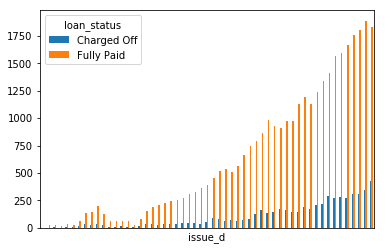

In [143]:
# timestamp features distribution
df_time = loans[['issue_d', 'loan_status']].dropna()
df_time.issue_d = [pd.datetime.strptime(str(j), '%b-%Y')
                           for j in df_time.issue_d.values]

pvt = pd.pivot_table(df_time, index = 'issue_d', columns = 'loan_status', aggfunc = len)
pvt.plot(kind = 'bar')
plt.xticks([])
plt.show()

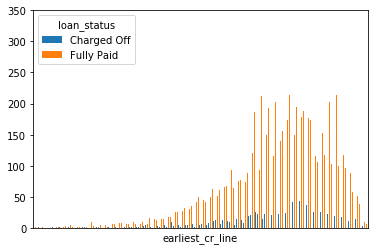

In [141]:
# timestamp features distribution
df_time = loans[['earliest_cr_line', 'loan_status']].dropna()
df_time.earliest_cr_line = [pd.datetime.strptime(str(j), '%b-%Y')
                           for j in df_time.earliest_cr_line.values]

pvt = pd.pivot_table(df_time, index = 'earliest_cr_line', columns = 'loan_status', aggfunc = len)
pvt.plot(kind = 'bar')
plt.xticks([])
plt.show()

### 3.2.5 文字特征分布
样本中的文本特征有：借款人所在地，借款描述，职位头衔

词云的优势是从大量文字样本中一眼看出文本的主要内容。

通过词云了解各个文本特征分布

In [15]:
"""
# text features distribution -- wordcloud
text_feas = ['addr_state', 'desc', 'emp_title']
str_list = ['', '', '']
# collect words into a 3 strings
for i, j in enumerate(text_feas):
  for item in loans[j].dropna().values:
    str_list[i] += str(item) + ' '
    
# make wordcloud: generate different size of word according to it's frequency
from wordcloud import WordCloud
for i in str_list:
  wordcloud = WordCloud().generate(i)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()
"""

"\n# text features distribution -- wordcloud\ntext_feas = ['addr_state', 'desc', 'emp_title']\nstr_list = ['', '', '']\n# collect words into a 3 strings\nfor i, j in enumerate(text_feas):\n  for item in loans[j].dropna().values:\n    str_list[i] += str(item) + ' '\n    \n# make wordcloud: generate different size of word according to it's frequency\nfrom wordcloud import WordCloud\nfor i in str_list:\n  wordcloud = WordCloud().generate(i)\n  plt.imshow(wordcloud)\n  plt.axis('off')\n  plt.show()\n"

按还款状态分类统计借款人所在州的分布：

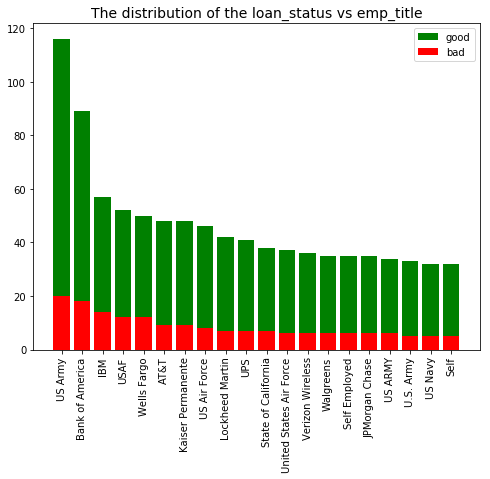

In [153]:
# text features distribution
# emp_title
y_0 = loans[loans.loan_status == 'Fully Paid'].emp_title.value_counts()[:20].values
y_1 = loans[loans.loan_status == 'Charged Off'].emp_title.value_counts()[:20].values
ind = loans[loans.loan_status == 'Fully Paid'].emp_title.value_counts()[:20].index
plt.figure(figsize = (8, 6))
plt.bar(ind, y_0, color = 'g')
plt.bar(ind, y_1, color = 'r')
plt.title("The distribution of the loan_status vs emp_title", size = 14, color = 'black')
# set xticks vertical
plt.xticks(ind, rotation = 'vertical') # 
plt.legend(['good', 'bad'])
plt.show()

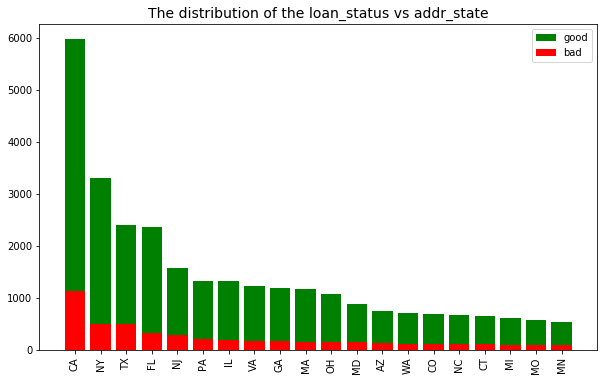

In [157]:
# text features distribution
# addr_state
y_0 = loans[loans.loan_status == 'Fully Paid'].addr_state.value_counts()[:20].values
y_1 = loans[loans.loan_status == 'Charged Off'].addr_state.value_counts()[:20].values
ind = loans[loans.loan_status == 'Fully Paid'].addr_state.value_counts()[:20].index
plt.figure(figsize = (10, 6))
plt.bar(ind, y_0, color = 'g')
plt.bar(ind, y_1, color = 'r')
plt.title("The distribution of the loan_status vs addr_state", size = 14, color = 'black')
# set xticks vertical
plt.xticks(ind, rotation = 'vertical') # 
plt.legend(['good', 'bad'])
plt.show()

From the results above：

The majority of the borrowers are from CA, NY, and TX, while most of the borrowers are from US Army, Bank of America, IMB, USAF, etc. 

借款人的区域来源，主要集中在加州、德州、纽约等等这些大州，后续数据处理可以考虑将这些主要区域提取出来。

职务头衔：借款人的职务背景按照数量分布依次是公司、军队、医院。。。

### 3.2.6 The correlation of each two features (两两特征的协方差)

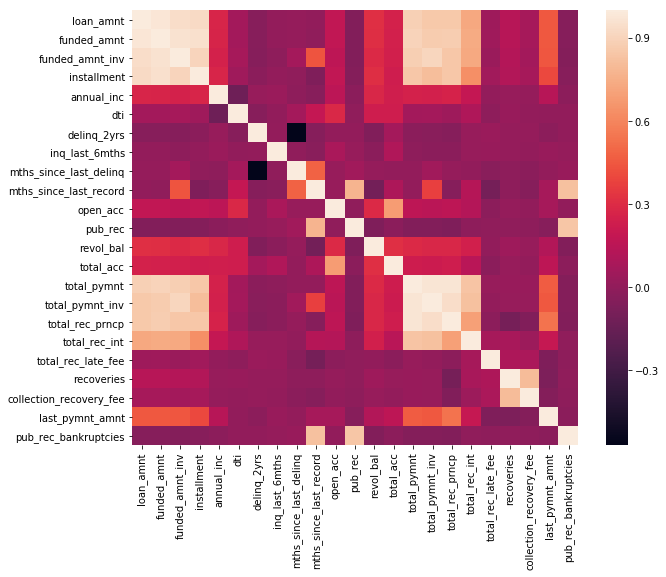

In [158]:
# feature's correlation
plt.figure(figsize = (10, 8))
sns.heatmap(loans.iloc[:, :50].corr())

上图中浅颜色的部分是表示特征相关度高，除了对角线的区域，其它区域也分布着高相关性特征对，这说明样本集中某些特征之间存在强线性相关性，这个问题在选用某些机器学习模型（比如基于线性回归的模型族）时会显著影响模型性能，需要引起注意。

# 4. Data preprocesing (数据预处理)

Based on the overview, after the first round data cleaning:

- number of features =  41, sample size = 39786
- there is a high percentage of missing values
- some numerical features are represented with special signs, e.g., %
- some of the features are correlated

## 4.1. training, validation, testing data seperation (数据集划分)
To avoid data leakage, it's better to split the datasets before data preprocessing. 

In [0]:
from sklearn.model_selection import train_test_split

# split the data
x_col = loans.columns.tolist()
x_col.remove('loan_status') # remove target variable from x
X = loans[x_col]
y = loans['loan_status']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 1)

df_train = pd.concat([x_train, y_train], axis = 1)
df_val = pd.concat([x_val, y_val], axis = 1)
df_test = pd.concat([x_test, y_test], axis = 1)

df_list = [df_train, df_val, df_test]

In [163]:
print("The shape of training dataset: {}".format(df_train.shape))
print("The shape of validation dataset: {}".format(df_val.shape))
print("The shape of testing dataset: {}".format(df_test.shape))

The shape of training dataset: (25462, 41)
The shape of validation dataset: (6366, 41)
The shape of testing dataset: (7958, 41)


## 4.2 Missing values replacement, process (特征缺失值识别与处理)

### 4.2.1 Features with high percentage of missing values (严重缺失值的处理)

Identify the features with 60% more missing values and process 
找到缺失超过６０％的特征，并进一步了解缺失情况

In [165]:
# default values
# select features which 60% of the data is missing
mis_feasures = [i for i in loans.columns if ((loans[i].isnull().sum())*1.0/loans.shape[0]) > 0.6]
# output missing rate to get a further understanding of missing info
for i in mis_feasures:
  mis_rate = (loans[i].isnull().sum()) * 1.0 / loans.shape[0]
  print(i, "\t", mis_rate)

mths_since_last_delinq 	 0.6466344945458201
mths_since_last_record 	 0.9298496958729201


From the result above, after the first round data cleaning, the above two featurs have more than 60% percentages of missing values. 

From the experience, the two features **mths_since_last_delinq（距离上次违约的月份数）、mths_since_last_record（距离上一次公共黑记录月份数）** should be helpful to the loan model evaluation. Thus, even though these two features have high percentages of missing values, I will keep these two features, and replace the missing values approapately. 

### 4.2.2 Missing values replacement (缺失值填充)

了解现有缺失值的情况，根据缺失比例，缺失值的具体信息含义，缺失特征性质，来决定处理策略：

In [170]:
# define missing value features to be filled
mis_feaures_to_fill = [i for i in loans.columns if loans[i].isnull().sum() != 0]
for i in mis_feaures_to_fill:
  mis_rate = (loans[i].isnull().sum() * 1.0/loans.shape[0])
  print(i, '\t', mis_rate)

emp_title 	 0.06200673603780224
emp_length 	 0.027094958025436083
title 	 0.000276479163524858
mths_since_last_delinq 	 0.6466344945458201
mths_since_last_record 	 0.9298496958729201
revol_util 	 0.0012567234705675363
last_pymnt_d 	 0.0017845473282059015
last_credit_pull_d 	 5.026893882270145e-05
pub_rec_bankruptcies 	 0.017518725179711456


>Features | Type | Missing pct | Fill strategy
>--- | --- | --- | ---
>emp_title | categorical | 6.2% | mode
>emp_length | categorical | 2.7% | mode
>title | categorical | 0.027% | mode
>mths_since_last_deling | numerical | 64.66% | missing value as one class
>mths_since_last_record | numerical | 92/98% | missing value as one class
>revol_util | categorical | 0.126% | mode
>last_pymnt_d | categorical | 0.178% | after approval of the loan, **drop**
>last_credit_pull_d | categorical | 0.005% | after approval of the loan, **drop**
>pub_rec_bankrupticies | categorical | 0.175% | mode

In [0]:
# update the features which need further processing later


#string, text features, need recoding
cat_features = ["term", "grade", "sub_grade", "emp_title", "emp_length", "home_ownership", "verification_status", "purpose","title", "addr_state"]

# numerical values with % sign, need recoding
text_features = ["int_rate", "revol_util", "total_acc"]

# date features
date_features = ["issue_d", "earliest_cr_line"]

#### 4.2.2.1 Fill with mode

In [0]:
from scipy.stats import mode

# fill with mode number
features_fill_with_mode = ["emp_title", "emp_length", "title", "revol_util", "last_pymnt_d", "last_credit_pull_d", "pub_rec_bankruptcies"]

for i in features_fill_with_mode:
  loans[i][loans[i].isnull()] = mode(loans[i][loans[i].notnull()])[0][0]

注：

由于接下来将用到逻辑回归模型，它对特征线性相关性较敏感，所以尽管用其它变量拟合缺失值对缺失值的填充会更符合实际情况，也没有采用这种方法。

为什么使用众数填充而不是用中位数或是均值填充？因为众数对于数值型变量和字符型变量都适用，而且也有统计意义。

### 4.3 Features with the same values
At the very beginning, the features with 100% missing values or 100% same values are removed. 

Next, I will focus on the other imbalanced features. 
In general, if the percentage of the featuers with 90% more same values will be problematic. 

如果一个变量大部分的观测都是相同的特征，那么这个特征或者输入变量就是无法用来区分目标时间，一般来说，临界点在90%。但是最终的结果还是应该基于业务来判断。

In [177]:
# 同值性特征识别处理，将阀值设定为90%
same_value_features = []
for i in loans.columns:
  try:
    mode_value = mode(loans[i])[0][0]
    mode_rate = mode(loans[i])[1][0]*1.0 / loans.shape[0]
    if mode_rate > 0.9:
      same_value_features.append([i, mode_value, mode_rate])
  except:
    pass
  
temp = pd.DataFrame(same_value_features, columns = ['col_name', 'mode_value', 'mode_rate'])
temp .sort_values(by = 'mode_rate')

,col_name,mode_value,mode_rate
2,collection_recovery_fee,0,0.903107
0,pub_rec,0,0.946690
1,total_rec_late_fee,0,0.947771
3,pub_rec_bankruptcies,0,0.957648
4,debt_settlement_flag,N,0.996230


>Features | Mode_value | Mode_rate | Strategy
>--- | --- | --- | ---
>collection_recovery_fee | 0 | 90% | after charged off, **drop**
>pub_rec | 0 | 94.7% | most borrowers don't have public recovery record, seems reasonable, **drop**
>total_rec_late_fee | 0 | 94.77% | after charged off, **drop**
>pub_rec_bankruptcies | 0 | 95.57% | most borrowers don't have public bankrupticy record, seems reasonable, **drop**


In [0]:
# remove the features from the training, validation, testing datasets
for data in df_list:
  data.drop(["collection_recovery_fee", "pub_rec", "total_rec_late_fee", "pub_rec_bankruptcies"], axis = 1, inplace = True)

### 4.4 Features format preprocessing

#### 4.4.1. remove %, 

#### 4.4.2. format time features

In [0]:
#string, text features, need recode, after further analysis, some of the features could be removed, I need to update the features for later data engineering
cat_features = ["term", "grade", "sub_grade", "emp_title", "emp_length", "home_ownership", "verification_status", "purpose","title", "addr_state"]

# numerical values with % sign, need recoding
text_features = ["revol_util", "total_acc", "int_rate"]

# date features
date_features = ["issue_d", "earliest_cr_line"]

In [0]:
for data in df_list:
  data['term'] = data['term'].replace(" 36 months", 36).replace(" 60 months", 60).astype('float')
  # remove %
  data['int_rate'] = data['int_rate'].str.replace('%', '').astype('float')
  data['revol_util'] = data['revol_util'].str.replace('%', '').astype('float')
  # format time features
  data['earliest_cr_line'] = [pd.datetime.strptime(str(j), '%b-%Y') for j in data['earliest_cr_line']]
  data['issue_d'] = [pd.datetime.strptime(str(j), '%b-%Y') for j in data['issue_d']]
  
  

### 4.5 Text features processing (文本特征处理)
- emp_title
- title
- addr_state

经过上述步骤处理后，现有的文本类数据包括：emp_title(职务信息），title(标题）,addr_state(借款人地址），其中title与purpose相关性较强，都是表明借款用途的信息。

emp_title字面上看是职务头衔，但是实际内容是借款人所在机构，它类型多，且是文本型特征，但是根据数据探索阶段得到的结论，这个变量含有预测性的信息，用模型分箱相当耗费性能，所以根据经验考虑尝试机构类别将它分类。

addr_state也包含预测性信息，可以尝试用卡方分箱或依据经验进行进行分类

### 4.5.1 工作机构分类 (暂时去掉)

Since there are 28862 distinct titles, will drop it temperally.

工作机构分类，依据A政府机构类，B银行类，F医院类，E学校类，C自职业类，D公司和其它类，G退休类分类． 如果数据中的emp_title与某个上述A-G有交集，则将它划为该类，用字母字符表示； 缺省值为’H'。

In [0]:
for data in df_list:
  data.drop("emp_title", axis = 1, inplace = True)
  

In [0]:
# 工作机构分类，依据A政府机构，B银行， F医院类， E学校类， C自由职业类，D公司和其它类， G退休类
# 如果loans中emp_title与某个上述工作有交集， 则将其化为该类， 用字母表示， 
# 缺失值用”H"代替

A = ['board', 'general', 'american', 'U.S.', 'army', 'force', 'states', 'corp', 'navy', 'united', 'department']
B = ['bank', 'morgan']
C = ['self']
D = 'OTHER'
E = ['college', 'school', 'university']
F = ['hospital', 'clinic', 'health', 'healthcare']
G = ['retired']

ls_letter = [0, 1, 2, 4, 5, 6]
ls = [A, B, C, E, F , G]

def emp_classify(df1):
  for i in df1.emp_title.index:
    emp_list = []
    for j in range(len(ls)):
      emp_list.append((set(str(df1.emp_title[i]).lower().split())&set(ls[j])))
    if emp_list.count(set()) != 6:
      sr_emp = pd.Series(emp_list)
      idx = sr_emp[sr_emp != set()].index
      df1.emp_title[i] = ls_letter[idx[0]]
    else:
      df1.emp_title[i] = 3
  df1.emp_title[df1.emp_title.isnull()] = 7

注：由于下面要应用到随机森林模型，它只接受数值型和类别型变量，不接受

‘object’或区间格式的变量，为了方便，将类别统一用数字表示。其它的格式变换也是如此。

### 4.5.2 借款人州地址分类 (暂时去掉)

Since there are 50 distinct states, will drop it temperally

４．５．２．１　k-means聚类分析

首先尝试使用k-means方式进行聚类，看看每一类中的州地址有没有什么共性：

In [210]:
# 尝试k-means 方法对所在州聚类
# K-means 是基于距离值聚类，因此需要先归一化处理

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
mm = MinMaxScaler()

"""
df_addr_temp.iloc[:, :] = mm.fit_transform(df_addr_temp)

km = KMeans(n_clusters = 8, random_state = 3)
km.fit(df_addr_temp.values)
df_addr_temp = pd.concat([df_addr_temp, df_train.addr_state, pd.Series(km.labels_)], axis = 1)

df_addr_temp.groupby([0, 'addr_state'])['addr_state'].count()
"""

"\ndf_addr_temp.iloc[:, :] = mm.fit_transform(df_addr_temp)\n\nkm = KMeans(n_clusters = 8, random_state = 3)\nkm.fit(df_addr_temp.values)\ndf_addr_temp = pd.concat([df_addr_temp, df_train.addr_state, pd.Series(km.labels_)], axis = 1)\n\ndf_addr_temp.groupby([0, 'addr_state'])['addr_state'].count()\n"

从输出结果中并没有看出不同群体有什么共性。

### 4.5.3 等频分箱 (暂时不考虑上面两个features)
用频数进行分类，使每一个分组内的样本数尽量相近

In [0]:
# 尝试用频数经行分类， 是每一个分组内的样本数尽量相近， 假设8个样本， 每个分组大约3300个样本

S= [['CA'], ['FL', 'TX'], ['NJ', 'PA', 'IL'], ['VA', 'GA', 'MA', 'OH'], ['MD', 'AZ', 'WA', 'CT', 'CO', 'NC'], 
   ['MI', 'MO', 'MN', 'NV', 'OR', 'WI', 'LA', 'SC', 'AL', 'OK']]

addr_list = df_train.addr_state.value_counts().index.tolist()

SS = []
for i in S:
  SS += i
  
S.insert(7, list(set(addr_list) - set(SS)))

addr_set = []
for i in S:
  addr_set.append(set(i))
  
addr_dict = {}
for i, j in zip(range(8), addr_set):
  addr_dict[i] = j
  
# 将addr_state 进行分类转换

def trans_add_func(df_to_trans):
  for i in df_to_trans.addr_state[10:]:
    for j in range(len(addr_dict)):
      if i in addr_dict[j]:
        df_to_trans.addr_state[df_to_trans.addr_state == i] = list(addr_dict.keys())[j]

### 4.6 Categorical features recoding (特征编码)

逻辑回归和随机森林模型不接受字符型变量，因此需要将对此类变量进行编码。

常用的编码方式有类别标签法（不同的类别映射到不同的数值），哑变量编码法（对类别变量取哑变量）等等。考虑到评分卡模型的简洁性，在此选用类别标签法。。

In [0]:
# encoding features: grade, emp_length, home_ownership, verification_status, purpose
import numpy as np

for data in df_list:
  
  # feature grade
  data.grade.replace({"A":0, "B":1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6}, inplace = True)
  
  # feature emp_length
  data.emp_length.replace({"10+ years": 11, "9 years": 10, "8 years": 19, "7 years": 8, 
                        "6 years": 7, "5 years": 6, "4 years": 5, "3 years": 4, 
                        "2 years": 3, "1 year": 2, "< 1 year": 1, np.nan: 0}, inplace = True)
  
  # feature home_ownership
  data.home_ownership.replace({"MORTGAGE": 0, "OTHER": 1, "NONE": 2, "OWN": 3, "RENT": 4}, inplace = True)
  
  # feature verification_status
  data.verification_status.replace({'Not Verified': 0, "Source Verified": 1, "Verified": 2}, inplace = True)
  
  # feature purpose
  data.purpose.replace({"credit_card": 0, "home_improvement": 1, "debt_consolidation": 2, "other": 3, 
                    "major_purchase": 4, "medical": 5, "small_business": 6, 
                    "car": 7, "vacation": 8, "moving": 9, "house": 10,
                    "renewable_energy": 11, "wedding": 12, "education": 13}, inplace = True)
  
  # feature loan_status
  data.loan_status.replace({"Fully Paid": 0, "Charged Off": 1}, inplace = True)
  
  # feature term
  data.term.replace({36.0: 0, 60.0: 1}, inplace = True)

### 4.7 Data normalization 归一化处理

逻辑回归模型基于线性回归，求参需要用到梯度下降法，为了加快迭代速度，不同特征的变化范围规模相差不宜过大，如果用数值直接带入逻辑回归模型，必须进行变量缩放。但是本文是用逻辑回归建立评分卡，会将数值变量进行分箱，所以这一步可以省略。

### 4.8 Be careful about data leakage (警惕数据泄露)

数据泄露分为２种：不恰当特征导致的泄露、不恰当的交叉验证策略导致泄露

### 4.8.1 警惕不恰当特征

所有特征中，一旦在目标属性出现后，会随之更新或出现的属性，属于会泄露信息的属性，在这个数据集中，包括贷中、贷后特征。

删除此类特征（之前预处理步骤中已经删除了一些）：



In [0]:
# delete leaking features & not meaningful features
leak_feas = ['sub_grade', 'title', 'zip_code', 'recoveries', 'last_pymnt_amnt', 'funded_amnt', 'funded_amnt_inv', 'total_pymnt',
            'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'desc']

for i in df_list:
  i.drop(leak_feas, axis = 1, inplace = True)

### 4.8.2 错误的交叉验证策略：
尽量保证验证集数据的纯粹，不要让它参与到训练集的处理和模型构建当中，这意味着，要在预处理之前分割训练集和测试集。

# 5. Feature Engineering


### 5.1 特征衍生 (之后再做)
将时序变量衍生为月份值，将（贷款发放时间－首次使用信用卡时间）作为一个新的变量，表示信用历史(cre_hist)，单位是月份。

In [216]:
# deriving features, cre_hist = issue_d - earliest_cr_line
"""
for i in df_list:
  i['cre_hist'] = [j.days for j in (i.issue_d - i.earliest_cr_line)/30]
  i.drop(['issue_d', 'earliest_cr_line'], axis = 1, inplace = True)
  
"""

"\nfor i in df_list:\n  i['cre_hist'] = [j.days for j in (i.issue_d - i.earliest_cr_line)/30]\n  i.drop(['issue_d', 'earliest_cr_line'], axis = 1, inplace = True)\n  \n"

### 5.2 筛选变量

### 5.2.1 依据共线性筛选变量

逻辑回归是基于线性回归模型，其前提假设是用于建模的特征之间不存在线性相关性，因此，它对共线性问题比较敏感。共线性的存在对模型稳定性有很大影响，并且也无法区分每个特征对目标变量的解释性。

依据VIF（方差膨胀系数）筛选变量

每个特征的VIF计算是用其它特征对它进行回归拟合，如果这种拟合的解释性很强，说明它们之间存在多重共线性。

用VIF计算连续型变量的共线性：

In [217]:
df_train.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'purpose', 'title', 'addr_state',
       'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'revol_bal', 'revol_util',
       'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'recoveries', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'debt_settlement_flag', 'loan_status',
       'cre_hist'],
      dtype='object')

In [220]:
df_train.select_dtypes(include=['object'])

,sub_grade,emp_length,purpose,title,addr_state,last_pymnt_d,last_credit_pull_d,debt_settlement_flag
15908,A2,7,3,pay off personal loan,TX,May-2014,Jul-2015,N
6796,A1,7,10,home down payment,NJ,May-2013,May-2013,N
33525,D3,3,1,Home Improvement,TX,Mar-2011,Mar-2011,N
49,A2,6,2,Debt Consolitation,CT,Jan-2015,Oct-2018,N
17697,B5,1,9,our new start,IL,Dec-2012,Jan-2016,N
33582,B5,11,2,On a Debt Free Adventure of my own!,TX,Dec-2012,Dec-2012,N
12642,B5,2,2,KC Consolidation,IL,Jul-2014,Nov-2017,N
18345,B3,6,3,Henrys loan,WA,Dec-2013,Aug-2018,N
7916,A4,1,2,Sweet 16,CA,Mar-2013,Oct-2018,N
15415,A3,4,7,Ducati,CA,Jun-2013,Jun-2013,N


In [218]:
# select number features 
vif_feas = [i for i in df_train.columns if i not in ['term', 'mths_since_last_delinq', 'mths_since_last_record', 'addr_state', 'emp_title', 'loan_status']]

# calcuate vif
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

vif_ls = []

for i in range(len(vif_feas)):
  vif_ls.append([vif_feas[i], vif(df_train[vif_feas].values, i)])
  
vif_df = pd.DateFrame(vif_ls, columns = ['col_name', 'vif'])
vif_df.sort_values(by = 'vif', ascending = False)

TypeError: ignored

用协方差计算线性相关性：

In [219]:
# calculate correlation
cor = df_train[vif_feas].corr()

# get lower trianglar matrix of cor
cor.iloc[:, :] = np.tril(cor.values, k = -1)

# stack columns of cor
cor = cor.stack()
cor[np.abs(cor) > 0.7]

funded_amnt      loan_amnt          0.982263
funded_amnt_inv  loan_amnt          0.940191
                 funded_amnt        0.958405
installment      loan_amnt          0.931552
                 funded_amnt        0.956158
                 funded_amnt_inv    0.905064
grade            int_rate           0.948789
total_pymnt      loan_amnt          0.883134
                 funded_amnt        0.899293
                 funded_amnt_inv    0.877632
                 installment        0.849600
total_pymnt_inv  loan_amnt          0.850530
                 funded_amnt        0.867096
                 funded_amnt_inv    0.909490
                 installment        0.810377
                 total_pymnt        0.971117
total_rec_prncp  loan_amnt          0.851999
                 funded_amnt        0.870039
                 funded_amnt_inv    0.845313
                 installment        0.846408
                 total_pymnt        0.972447
                 total_pymnt_inv    0.940453
total_rec_

根据经验，vif>10,cor>0.7,变量之间的有显著性的相关性。

从上述关于协方差和VIF的分析结果中我们可以看到：installment&loan_amnt，int_rate&grade，total_acc&open_acc，pub_rec_bankruptcies&pub_rec之间存在线性关系，因为pub_rec_bankruptcies&pub_rec中大多数都是０，所以其有相关可以解释。剩下的几对，我们可以尝试先删除每对中的一个,删除installment & grade,再去检测相关系数。

此外，有几个处于边界地带的特征，暂时留下，特征工程中删除特征时要谨慎，因为删除特征，意味着弃用一些信息。

In [0]:
for i in ["installment", "grade"]:
  vif_feas.remove(i)
  
for i in df_list:
  i.drop(["installment", "grade"], axis = 1, inplace = True)

### 5.2.2 依据特征重要性筛选变量

筛选变量常用的方法有，基于正则化损失函数的线性模型，基于机器学习模型输出的特征重要性，基于IV值。

在此，为了方便进行评分卡建模，采用IV值.

定义woe和iv:

In [0]:
# calcualte woe and IV 

def CalcWOE(df, col, target):
  total = df.groupby([col])[target].count()
  total = pd.DataFrame({"total": total})
  bad = df.groupby([col])[target].sum()
  bad = pd.DataFrame({"bad": bad})
  regroup = total.merge(bad, left_index = True, right_index = True, how = "left")
  regroup.reset_index(level = 0, inplace = True)
  N = sum(regroup["total"])
  B = sum(regroup["bad"])
  regroup["good"] = regroup["total"] - regroup["bad"]
  G = N - B 
  regroup["bad_pcnt"] = regroup["bad"].map(lambda X: X * 1.0/B)
  regroup["good_pcnt"] = regroup["good"].map(lambda X: X * 1.0/G)
  
  # WOE 在这里显示不同特征不同属性对好样本的预测能力， 这符合评分卡计分标准， 分数越高， 越可靠
  regroup["WOE"] = regroup.apply(lambda X: np.log(X.good_pcnt * 1.0 / X.bad_pcnt))
  WOE_dict = regroup[[col, "WOE"]].set_index(col).to_dict()
  IV = regroup.apply(lambda X: (X.good_pcnt - X.bad_pcnt) * np.log(X.good_pcnt * 1.0 / X.bad_pcnt), axis = 1)
  IV_SUM = sum(IV)
  return {"WOE": WOE_dict, "IV_SUM": IV_SUM, "IV": IV}

计算每个变量的IV 值并按从大到小的顺序排序：

In [0]:
# calcualte IV
df_train_boxed = df_train.copy()

In [73]:
# get IV
iv_list = []
for i in df_train_boxed.columns:
  iv_dict = CalcWOE(df_train_boxed, i, "loan_status")
  iv_list.append(iv_dict["IV_SUM"])
  
# get IV form

iv_df = pd.DataFrame({"iv_name": df_train_boxed.columns.values, "iv": iv_list})

iv_df.sort_values('iv', ascending = False)

TypeError: ignored

如果输出IV值是无穷，说明该特征中某些属性中缺失某类样本，这需要重新分箱，将这类样本添加到相邻类（对于连续型数值样本）或样本数量较少的那一类（对于分类样本）中去： deling_2yrs:把7.0,8.0,9.0,11.0划归到7.0那一类,全算作6.0

home_ownership:把2添加到1 这一类

pub_rec：把3.0，4.0，添加到2.0这一类

In [74]:
#实施上述区间合并
for df_i in df_list:
  df_i.delinq_2yrs[df_i.delinq_2yrs.isin([7.0, 8.0, 9.0, 11.0])] = 6.0
  df_i.home_ownership[df_i.home_ownership == 2] = 1
  df_i.pub_rec[df_i.pub_rec.isin([3.0, 4.0])] = 2.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


保留IV大于0.15的特征：

In [75]:
# 保留IV值> 0.015的变量
valid_feas = iv_df[iv_df.iv > 0.015].iv_name.tolist()
valid_feas.remove('loan_status')

NameError: ignored

In [76]:
valid_feas

NameError: ignored

### 5.3 特征分箱
特征分箱就是把连续特征转化为离散特征，或者减小离散特征的离散性。

特征分箱有如下好处：

特征分箱后，特征被简化，也简化了模型，比如在逻辑回归评分卡模型中，评分卡被简化，基于决策树的模型中，决策树枝杈减少，降低了过拟合的风险，有效增加了模型的稳定性。

特征分箱可以将缺失值划为一类，比如此样本中无法被编码的公共记录缺失类。

特征离散化后对异常数据也有更强的容错性。比如假设年龄数据中出现１０００岁，模型可以自动将其划分为>80岁一类，否则它会对对异常值敏感的模型如（逻辑回归）造成很大影响。

特征离散化之后，方便进一步进行非线性的特征衍生。

分箱的方法：

常用的分箱方法包括卡方分箱、等频或等距分箱、聚类、依据经验分箱等。

对连续型数值变量，在此采用有监督的最优分箱法——卡方分箱。

定义卡方分箱函数：

In [0]:
# 卡方分箱
def Chi2(df, total_col, bad_col, overallRate):
  df2 = df.copy()
  df2["expected"] = df[total_col].apply(lambda X: X * overallRate)
  combined = zip(df2["expected"], df2[bad_col])
  chi = [(i[0] - i[1]) ** 2/i[0] for i in combined]
  chi2 = sum(chi)
  return chi2
  
def ChiMerge_MaxInterval_original(df, col, target, max_interval = 5):
  colLevels = set(df[col])
  colLevels = sorted(list(colLevels))
  N_distinct = len(colLevels)
  if N_distinct <= max_interval:
    print("The row number cann't be less than interval numbers")
    return colLevels[:-1]
  
  else:
    total = df.groupby([col])[target].count()
    total = pd.DataFrame({"total": total})
    bad = df.groupby([col])[target].sum()
    regroup = total.merge(bad, left_index = True, right_index = True, how = "left")
    regroup.reset_index(level = 0, inplace = True)
    N = sum(regroup["total"])
    B = sum(regroup["bad"])
    overallRate = B * 1.0 / N 
    groupIntervals = [[i] for i in colLevels]
    groupNum = len(groupIntervals)

### 5.3.1 对无缺省值的连续型数值变量分箱

对连续型数值变量实施分箱，得到切割点
8 intervals for the features

loan_amnt, int_rate, annual_inc, dti, open_acc, revol_bal, revol_util, total_acc, cre_hist

 |loan_amnt| int_rate|annual_inc|dti|open_acc|

In [81]:
num_feas_to_box

NameError: ignored

In [82]:
# by the sequence of the num_feas_to_box
cut_points_list = [
    [4450.0, 6000.0, 7725.0, 9750.0, 12200.0, 14275.0, 17800.0, 22875.0, 29900.0],
    [6.03, 7.75, 9.99, 13.99, 16.01, 17.49, 18.99, 20.3, 21.67],
    [26004.0, 37225.0, 40560.0, 48156.0, 51669.0, 62851.0, 74143.68, 89092.0, 115275.0],
    [2.53, 4.18, 6.45, 9.65, 12.47, 15.62, 19.31, 21.03, 23.87],
    [2.0, 3.0, 5.0, 6.0, 15.0, 20.0, 26.0, 30.0, 32.0],
    [1098.1, 2838.2, 4632.6, 6577.0, 8841.0, 11465.0, 14833.0, 19816.2, 29139.5], 
    [10.17, 21.4, 29.7, 42.0, 55.3, 68.0, 80.5, 92.7, 96.5], 
    [3.0, 4.0, 14.0, 26.0, 36.0, 43.0, 50.0, 60.0, 69.0],
    [55, 104, 186, 220, 314, 376, 425, 473, 525]    
]

cut_points_dict = {}
for i in range(len(num_feas_to_box)):
  cut_points_dict[num_feas_to_box[i]] = cut_points_list[i]

NameError: ignored

制作切割点字典：

实施分箱：

In [0]:
# 用卡方分箱得到的分割点经行分箱，要注意， 所有数据集中同样的特征区间都必须是相同的
def box_col_to_df(df_to_box, col, cut_points):
  bins = [-10.0] + cut_points + [10000000.0]
  # 如果有重复切割点， duplicates = 'drop'去重
  df_to_box[col] = pd.cut(df_to_box[col], bins = bins, include_lowest = True, duplicates = "drop",
                         labels = range(len(bins) - 1))

### 5.3.2 对含有缺省值的连续型数值变量分箱

对两个比较特殊的变量mths_since_last_delinq’和'mths_since_last_record'，它们也是属于连续型特征变量，但是却存在缺失值，分箱策略是将缺失值作为一类，其他类进行卡方分箱。

得到２者的切割点：

‘mths_since_last_delinq’:
[19.0, 33.0, 38.0, 63.0]

'mths_since_last_record':

[46.0, 68.0, 79.0, 82.0]

In [0]:
# 对 mths_since_last_delinq & mths_since_last_record 分箱编写函数
def box_mth_col(df_to_box, mth_col, bins):
  bins = [0.0] + [1.0] + bins + [150.0]
  df_to_box[mth_col][df_to_box[mth_col].notnull()] = pd.cut(
  df_to_box[mth_col][df_to_box[mth_col].notnull()], bins = bins, include_lowest = True, labels = range(len(bins) - 1))
  df_to_box[mth_col][df_to_box[mth_col].isnull()] = -1

将所有变量分箱后的效果如下：



# 6. Model  building

经过之前的数据处理和特征工程，得到了分箱后的，规整的数据，并且找到了对评分卡来说，高预测性能的特征。

这部分我会建立１个传统的评分卡和１个较复杂解释性较差但预测性较好的随机森林模型。

### 6.1 建立评分卡

在５．２．２节，得到了每个特征中不同属性的woe值，它的含义是该分类对“好结果”的贡献度。

建立评分卡的步骤如下：

用woe值替换相应位置的属性值

建立逻辑回归模型

根据回归结果计分

实施：

In [89]:
# 用WOE 替代相应位置的属性值
"""
df_card_train = df_train[valid_feas + ["loan_status"]]
df_card_test = df_test[valid_feas + ["loan_status"]]

for i in range(len(valid_feas)):
  df_card_train[valid_feas[i]].replace(iv_dict[valid_feas[i]]["WOE"]["WOE"], inplace = True)
  df_card_test[valid_feas[i]].replace(iv_dict[valid_feas[i]]["WOE"]["WOE"], inplace = True)
"""  
# 简历逻辑回归模型
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(df_card_train.drop("loan_status", axis = 1), df_card_train["loan_status"])

NameError: ignored

评估模型的预测性能

In [90]:
from sklearn.metrics import roc_auc_score, roc_curve
auc = roc_auc_score(LR.predict(df_card_test.drop("loan_status", axis = 1)), df_card_test["loan_status"])
fpr, tpr, thre = roc_curve(LR.predict(df_card_test.drop("loan_status", axis = 1)), df_card_test["loan_status"])
ks = max(tpr-fpr)

NameError: ignored

In [0]:
print("auc:{}     ks: {}".format(auc, ks))

auc约为0.672,ks值约为0.35,在评分卡建模中，ks值大于0.3，说明这是一个基本可用的模型。



输出评分卡：

In [0]:
# 输出评分卡
import statsmodels.api as sm

# df_card_train = sm.add_constant(df_card_train)

logit = sm.Logit(df_card_train["loan_status"].values, df_card_train.drop("loan_status", axis = 1).values).fit()

B = 20/np.log(2)
A = 600 + 20 * np.log(1/60)/np.log(2)
besescore = round(A - B * logit.params[0] 0)
scorecard = []

# features, remove("loan_status")
for j, i in enumerate(valid_feas + ["loan_amnt"]):
  woe = iv_dict[i]["WOE"]["WOE"]
  interval = []
  scores = []
  for key, value in woe.items():
    score = round(-(value * logit.params[j] * B))
    scores.append(score)
    interval.append(key)
  data = pd.DataFrame({"interval": interval, "scores": scores})
  scorecard.append(data)


### 6.2 建立随机森林模型

评分卡的优势在于简单明了，但是它无法包含更多的信息。随机森林的是以决策树为弱学习模型通过bagging方法构造出的强学习模型，它能容纳更多的信息，同时通过多模型投票，又能很好的避免过拟合的影响，它正好弥补了这一缺陷。这一模型可以作为评分卡的参考。

In [93]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
RF.fit(df_train.drop("loan_status"), axis = 1).values, df_train["loan_status"].values

KeyError: ignored

用网格搜索的方式优化逻辑回归森林模型：

回归森林模型中，n_estimators表示底层决策树个数，一般来说，树的个数越多，模型的稳定性越强，但是它的增大要受限于计算性能

In [94]:
# 网格搜索油画模型， 对随机森林中的DT个数经行遍历

from sklearn.model_selection import GridSearchCV
RF = RandomForestClassifier()
parameters = {"n_estimators": [5, 10, 20, 35, 50, 100]}

gs = GridSearchCV(estimator = RF, param_grid = parameters, scoring = "roc_auc", cv = 5, n_jobs = -1)

grid_result = gs.fit(df_train.drop("loan_status", axis = 1).values, df_train.loan_status.values)

ValueError: ignored

# 7. conclusion
在评估小微企业信贷风险时，个人信用评分只是其中一个环节，还应该综合考虑借贷人的经营情况,出借方的风险偏好等其他因素，构建风控策略和风控系统。

## useful reference:
URL_1 = 'https://blog.csdn.net/zs15321583801/article/details/89485951' **(example)**

URL_2 = "https://www.jianshu.com/p/a8037a38e219"

URL_3 = "https://zhuanlan.zhihu.com/p/21550547"